# Exploratory Data Analysis (EDA) — Reference Data Understanding

## Objective

The purpose of this notebook is to establish a **deep understanding of the raw dataset** before it is used to define reference data and simulate production batches for model monitoring.

This EDA serves as the **foundation for all downstream monitoring logic** by identifying:
- Feature types 
- Target class balance and risk 
- Data quality and schema issues
- Features that are likely to drive data drift, performance degradation or bias

The analysis focuses on:
- Feature distributions and semantics
- Target imbalance and its modeling implications
- Known data quality risks (e.g., type inconsistencies, missing values)

**Important note:**  
No data cleaning, feature encoding or model training is performed in this notebook.  
All transformations and fixes identified here will be implemented explicitly in the data pipeline to ensure reproducibility and enforce a clear data contract.

In [14]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling for reproducible file access
from pathlib import Path

# Display & visualization setup
# Shows all columns during inspection to avoid hidden schema issues
pd.set_option("display.max_columns", None)

# Using a clean, presentation-friendly style for all plots
sns.set_theme(style="whitegrid", context="notebook")

# Ensuring consistent figure sizing across the notebook
plt.rcParams["figure.figsize"] = (10, 5)

In [15]:
# Loading raw dataset
RAW_DATA_PATH = Path("data/raw/telco_customer_churn.csv")
df = pd.read_csv(RAW_DATA_PATH)

In [16]:
df.shape

(7043, 21)

## Dataset Size Overview

The dataset contains **7,043 customer records** with **21 columns**, including the target variable `Churn`.

This size is appropriate for:
- Training a stable baseline classification model
- Simulating multiple production batches
- Computing reliable data drift, performance and bias metrics

The dataset is large enough to support group-level fairness analysis.

In [17]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Initial Data Inspection

Inspecting the first few records confirms that the dataset contains a mix of:
- Numeric features (e.g., `tenure`, `MonthlyCharges`)
- Binary and multi-class categorical features (e.g., `Contract`, `PaymentMethod`)
- A human-readable binary target variable (`Churn`)

The structure reflects a realistic production schema with heterogeneous feature types.
This validates that downstream challenges such as encoding, schema consistency, and drift detection are representative of real-world ML systems.
Early inspection also suggests potential data quality issues (e.g., `TotalCharges`
stored as text).

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Schema & Data Type Inspection

Feature types reveal a heterogeneous schema:
- 18 categorical (`object`) features
- 2 numeric integer features (`tenure`, `SeniorCitizen`)
- 1 numeric continuous feature (`MonthlyCharges`)
- 1 identifier column (`customerID`)
- 1 binary target variable (`Churn`)

A critical schema issue is observed: `TotalCharges` is stored as an object despite being a numeric financial feature. Although no null values are reported,
subsequent inspection reveals blank strings, indicating hidden missingness.

This observation is important for:
- Preventing model training failures
- Avoiding false drift alerts
- Ensuring explainability stability
- Enforcing a reliable data contract in production

Based on this inspection, `customerID` is excluded from modeling and monitoring,
while `TotalCharges` requires explicit type enforcement before downstream use.

## Important column observations


In [19]:
# Target Variable
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Target Variable Analysis — Churn

The target variable **Churn** indicates whether a customer has discontinued the service.
Understanding its distribution is critical because it directly influences:

- Model evaluation strategy
- Production monitoring metrics
- Business risk exposure from model failure

### Class Distribution
The dataset exhibits the following class proportions:

- **Non-churn (No): ~73.5%**
- **Churn (Yes): ~26.5%**

This represents a **moderately imbalanced binary classification problem**.

### Business & Modeling Implications
Although churned customers are the minority class, they carry **disproportionately high business impact**.
A model that predicts “No churn” most of the time may achieve high accuracy while failing to identify customers at risk of leaving.

Consequently:
- **Recall for the churn class** is a primary metric, as false negatives correspond to missed retention opportunities.
- **Precision** is monitored to balance the cost of unnecessary retention actions.
- **ROC-AUC** is used as a threshold-independent metric to track ranking quality and model stability over time.

### Monitoring Perspective
In production, a silent decline in **churn recall** is more dangerous than a small drop in overall accuracy.
Therefore, recall for the churn class will be explicitly tracked across production batches, and significant drops will be treated as early indicators of model degradation requiring investigation or retraining.

In [20]:
# classification of feature types
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(exclude=["object"]).columns.tolist()

categorical_features, numerical_features

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TotalCharges',
  'Churn'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

### observations:
- `SeniorCitizen` is numeric but represents a binary category.
- `TotalCharges` appears numeric but is stored as string in raw data.
- Feature type decisions will directly affect drift detection logic later.


In [21]:
# Missing values 
df.isna().sum().sort_values(ascending=False)

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64

In [22]:
df["MonthlyCharges"].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

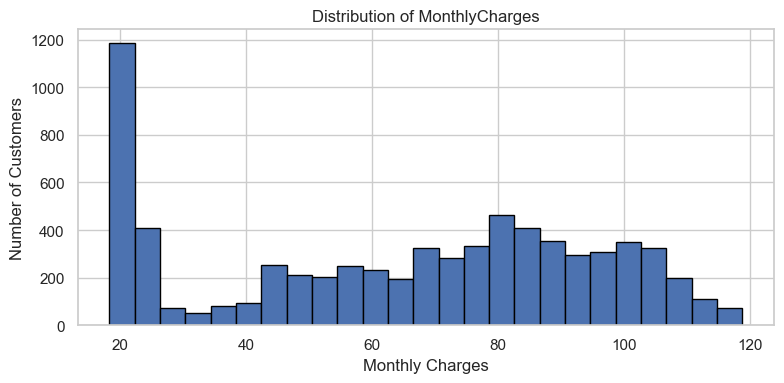

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(df["MonthlyCharges"], bins=25, edgecolor="black")
plt.title("Distribution of MonthlyCharges")
plt.xlabel("Monthly Charges")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

In [24]:
df.groupby("Churn")["MonthlyCharges"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


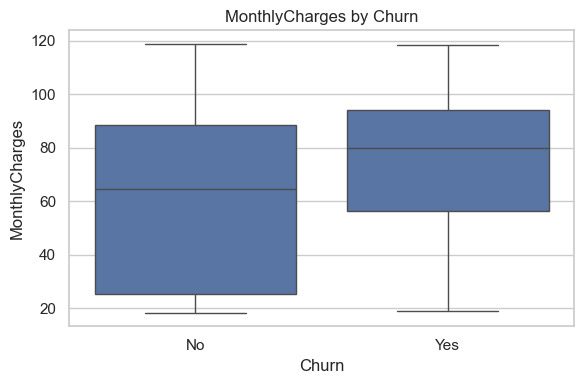

In [25]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, showfliers = False)
plt.title("MonthlyCharges by Churn")
plt.tight_layout()
plt.show()

### Feature Analysis — MonthlyCharges

**MonthlyCharges** represents the monthly billing amount charged to a customer and is directly linked to pricing strategy and customer value.

#### Distribution Overview
- **Range:** 18.25 to 118.75  
- **Median:** 70.35  
- **IQR:** 35.50 to 89.85  

The distribution is **right-skewed and multi-modal**, reflecting multiple pricing tiers (basic vs bundled/premium plans).

#### Relationship with Churn
A clear pricing effect is observed:

- **Non-churned customers:**  
  Mean ≈ 61.3, Median ≈ 64.4  
- **Churned customers:**  
  Mean ≈ 74.4, Median ≈ 79.7  

The boxplot confirms a consistent upward shift in MonthlyCharges for churned customers, indicating that **higher pricing is strongly associated with increased churn risk**.

#### Modeling Implications
- MonthlyCharges is a **high-impact numeric feature**
- Retaining continuous granularity is preferred
- Linear and tree-based models can effectively leverage its monotonic relationship with churn

#### Monitoring & Drift Implications
- MonthlyCharges is **high-risk for data drift** due to pricing changes, promotions, and new product bundles
- Drift in this feature can cause rapid performance degradation
- MonthlyCharges drift should carry **high severity weight** and trigger early alerts

In [26]:
# Evaluation of Totalcharges column
# blank strings in TotalCharges
num_blank = (df["TotalCharges"].str.strip() == "").sum()
num_blank

np.int64(11)

In [27]:
# rows with blank TotalCharges
blank_values = df["TotalCharges"].str.strip() == ""
df.loc[blank_values, ["customerID", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]]
df.loc[blank_values]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


### Data Quality Analysis — TotalCharges

`TotalCharges` is a **numeric financial feature**, but it is stored as an `object` column.
Exploratory analysis reveals the presence of **blank string values**, which represent missing data rather than valid numeric entries.

Inspection of affected rows shows that these blanks occur almost exclusively for customers with **very low tenure**, indicating newly onboarded customers who have not yet accumulated billing history. This suggests the issue originates from the **data generation process**, not random corruption.

#### Risks if Unaddressed
Leaving `TotalCharges` in its raw form can cause multiple production risks:
- Model training may fail or behave inconsistently due to mixed data types
- Drift metrics (mean shift, PSI) may produce misleading signals
- Explainability methods (e.g., SHAP) may break or yield unstable results

#### Resolution Strategy
To enforce schema consistency:
- Blank strings must be converted to `NaN`
- The column must be explicitly cast to numeric

This step is treated as **data contract enforcement**, not optional cleaning.

Because `TotalCharges` is a high-impact financial feature, any future appearance of non-numeric values should be flagged as a **schema-level violation**, not interpreted as genuine data drift.

In [28]:
df["tenure"].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [29]:
df.groupby("Churn")["tenure"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


<Axes: xlabel='Churn', ylabel='tenure'>

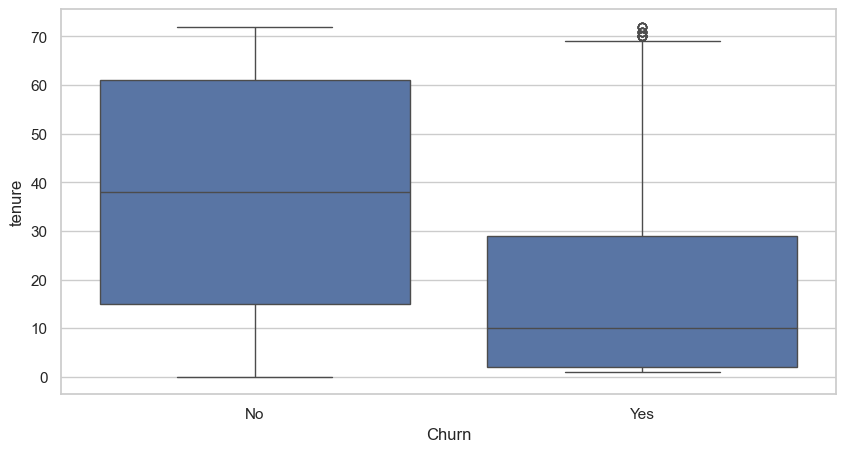

In [30]:
sns.boxplot(x="Churn", y="tenure", data=df)

### Interpretation & Findings
`tenure` measures the number of months a customer has stayed with the service.  
It is a continuous numeric feature with a strong behavioral interpretation: **customer loyalty and lifecycle stage**.

### Distribution Overview

From the descriptive statistics:

- **Range:** 0 to 72 months  
- **Median tenure:** 29 months  
- **Interquartile range (IQR):** 9 to 55 months  
- The distribution is **right-skewed**, with many short-tenure customers and a long tail of long-term subscribers.

### Relationship with Churn

- **Non-churned customers**
  - Mean tenure: ~37.6 months  
  - Median tenure: 38 months  

- **Churned customers**
  - Mean tenure: ~18.0 months  
  - Median tenure: 10 months  

The boxplot confirms that:

- Customers who churn tend to do so **early in their lifecycle**
- Long-tenure customers are **significantly more stable**
This makes `tenure` one of the **strongest predictive drivers of churn** in the dataset.

### Monitoring & Drift Implications

`tenure` is a **high-risk feature for data drift** because:

- New customer acquisition strategies can shift the distribution
- Pricing or onboarding changes may increase short-tenure users
- Seasonal campaigns can alter lifecycle composition

Because of its strong influence on predictions:
- Even **moderate drift** in `tenure` can cause performance degradation


/var/folders/zx/zzkcz9dd5lbc989qgmmvx9mh0000gn/T/ipykernel_78757/3119325842.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


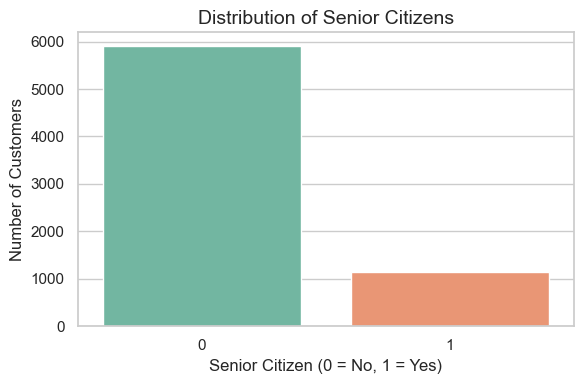

In [31]:
# SENIOR CITIZEN

plt.figure(figsize=(6, 4))
sns.countplot(
    x="SeniorCitizen",
    data=df,
    palette="Set2"
)

plt.title("Distribution of Senior Citizens", fontsize=14)
plt.xlabel("Senior Citizen (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()

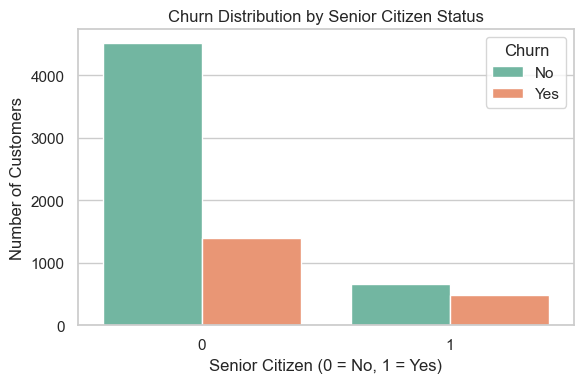

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x="SeniorCitizen",
    hue="Churn",
    data=df,
    palette="Set2"
)

plt.title("Churn Distribution by Senior Citizen Status")
plt.xlabel("Senior Citizen (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

In [33]:
df.groupby("SeniorCitizen")["Churn"].value_counts(normalize=True)

SeniorCitizen  Churn
0              No       0.763938
               Yes      0.236062
1              No       0.583187
               Yes      0.416813
Name: proportion, dtype: float64

## EDA Conclusions & Monitoring Implications

Key findings from exploratory analysis:

- Churn is a moderately imbalanced target with high business risk
- Tenure is the strongest behavioral predictor of churn
- MonthlyCharges exhibits price sensitivity and strong churn association
- SeniorCitizen is a numeric-but-categorical feature with fairness implications
- TotalCharges requires schema correction before use

Monitoring implications:

- Tenure and MonthlyCharges must be high-priority drift features
- Churn recall must be monitored more closely than accuracy
- SeniorCitizen requires group-wise performance monitoring
- Schema violations should be surfaced as errors, not drift

These findings directly inform:
- Feature preprocessing
- Drift severity weighting
- Performance alert thresholds
- Bias monitoring design